Importing Libraries

In [1]:
from typing import TypedDict , Dict
from langgraph.graph import StateGraph , END , START
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod


Define State Structure

In [2]:
class State(TypedDict):
    query:str
    category:str
    sentiment:str
    response:str

In [5]:
from dotenv import load_dotenv
import os
load_dotenv()
groq_api_key = os.getenv("groq_api_key")

In [9]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0,
    groq_api_key = groq_api_key,
    model_name = "llama-3.3-70b-versatile"
)
llm.invoke("What is langchain ?")

AIMessage(content='LangChain is an open-source framework designed to help developers build applications that utilize large language models (LLMs) more efficiently. It was created to simplify the process of integrating LLMs into various projects, allowing developers to focus on building their applications rather than worrying about the underlying infrastructure.\n\nLangChain provides a set of tools and libraries that enable developers to:\n\n1. **Interact with LLMs**: LangChain offers a unified interface to interact with different LLMs, such as LLaMA, PaLM, and others, making it easier to switch between models or use multiple models in a single application.\n2. **Manage memory and caching**: LangChain includes features to manage memory and caching, which helps to reduce the computational resources required to run LLMs and improves overall performance.\n3. **Implement indexing and retrieval**: LangChain provides tools for indexing and retrieving data from LLMs, making it easier to build 

In [19]:
def categorize(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following customer query into one of these categories: "
        "Technical, Billing, General. Query: {query}"
    )
    chain = prompt | llm
    category = chain.invoke({"query": state['query']}).content
    return {"category": category.strip()}  # Fixed dictionary syntax and added strip()

def sentiment_analysis(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Analyze the sentiment of the following customer query. "
        "Respond with either 'Positive', 'Neutral', or 'Negative'. Query: {query}"
    )
    chain = prompt | llm
    sentiment = chain.invoke({"query": state['query']}).content
    return {"sentiment": sentiment.strip()}  # Fixed typo and dictionary syntax

def handle_technical(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide technical support for the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state['query']}).content
    return {"response": response}  # Fixed dictionary syntax

def handle_billing(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide billing support for the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state['query']}).content
    return {"response": response}  # Fixed dictionary syntax

def handle_general(state: State) -> State:
    prompt = ChatPromptTemplate.from_template(
        "Provide general support for the following query: {query}"
    )
    chain = prompt | llm
    response = chain.invoke({"query": state['query']}).content
    return {"response": response}  # Fixed dictionary syntax

def escalate(state: State) -> State:
    return {"response": "This query has been escalated to a human agent due to its negative sentiment"}

def route_query(state: State) -> str:  # Fixed return type annotation
    if state['sentiment'] == "Negative":
        return "escalate"
    elif state['category'] == "Technical":
        return "handle_technical"
    elif state['category'] == 'Billing':
        return "handle_billing"
    else:
        return "handle_general"

In [ ]:
workflow.add_node("categorize", categorize)
workflow.add_node("analyze_sentiment", sentiment_analysis)  # Fixed spelling to match
workflow.add_node("handle_technical", handle_technical)
workflow.add_node("handle_billing", handle_billing)
workflow.add_node("handle_general", handle_general)
workflow.add_node("escalate", escalate)

# Add edges
workflow.add_edge("categorize", "analyze_sentiment")

# Conditional routing - keys must match route_query return values
workflow.add_conditional_edges(
    "analyze_sentiment",
    route_query,
    {
        "handle_technical": "handle_technical",
        "handle_billing": "handle_billing", 
        "handle_general": "handle_general",
        "escalate": "escalate"
    }
)

# Terminal edges
workflow.add_edge("handle_technical", END)
workflow.add_edge("handle_billing", END)
workflow.add_edge("handle_general", END)
workflow.add_edge("escalate", END)

workflow.set_entry_point("categorize")
app = workflow.compile()

In [23]:
workflow

In [26]:
!pip install graphviz

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


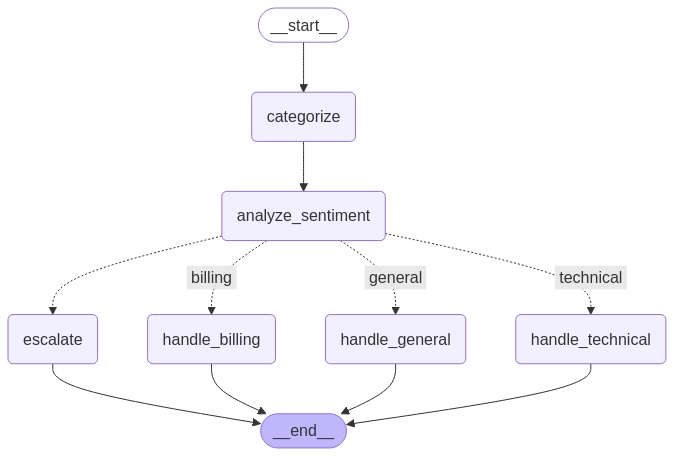

In [29]:
app

In [30]:
def run_customer_support(query:str)->Dict[str , str]:
    results = app.invoke({"query":query})
    return {
        "category":results['category'],
        "sentiment":results['sentiment'],
        "response":results['respose']
        
    }

In [31]:
run_customer_support("My internet connection is very slow , Can you help ?")

KeyError: 'handle_general'